In [1]:
import pandas as pd
from pathlib import Path

train_path = "../02_Data/Processed/sp500_tabular_train.csv"
val_path = "../02_Data/Processed/sp500_tabular_val.csv"
test_path = "../02_Data/Processed/sp500_tabular_test.csv"

df_train = pd.read_csv(train_path, parse_dates=["Date"])
df_val = pd.read_csv(val_path, parse_dates=["Date"])
df_test = pd.read_csv(test_path, parse_dates=["Date"])

print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
print("Test shape:", df_test.shape)
df_train.head()


Train shape: (736, 15)
Val shape: (250, 15)
Test shape: (487, 15)


,Date,Close,High,Low,Open,Volume,log_return,ma_5,ma_20,rolling_vol_20,sentiment_mean,sentiment_pos_mean,sentiment_neg_mean,news_count,target_next_return
0,2020-01-31,3225.520020,3282.330078,3214.679932,3282.330078,4.529700e+09,-0.017864,3260.489941,3279.220496,0.007441,0.0,0.0,0.0,1.0,0.007228
1,2020-02-03,3248.919922,3268.439941,3235.659912,3235.659912,3.760460e+09,0.007228,3261.547949,3279.923987,0.007463,0.0,0.0,0.0,1.0,0.014869
2,2020-02-04,3297.590088,3306.919922,3280.610107,3280.610107,3.996900e+09,0.014869,3265.817969,3282.489490,0.008129,0.0,0.0,0.0,1.0,0.011188
3,2020-02-05,3334.689941,3337.580078,3313.750000,3324.909912,4.121480e+09,0.011188,3278.075977,3287.364990,0.008401,0.0,0.0,0.0,1.0,0.003320
4,2020-02-06,3345.780029,3347.959961,3334.389893,3344.919922,3.887250e+09,0.003320,3290.500000,3292.001489,0.008375,0.0,0.0,0.0,1.0,-0.005415


In [2]:
target_col = "target_next_return"

exclude_cols = ["Date", target_col]

feature_cols = [c for c in df_train.columns if c not in exclude_cols]
print("Number of features:", len(feature_cols))
print("First features:", feature_cols[:10])

X_train = df_train[feature_cols].values
y_train = df_train[target_col].values

X_val = df_val[feature_cols].values
y_val = df_val[target_col].values

X_test = df_test[feature_cols].values
y_test = df_test[target_col].values


Number of features: 13
First features: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'ma_5', 'ma_20', 'rolling_vol_20', 'sentiment_mean']


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

def regression_summary(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # this is always MSE
    rmse = float(np.sqrt(mse))               # turn it into RMSE
    # simple directional accuracy
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    mask = sign_true != 0
    dir_acc = float(np.mean(sign_true[mask] == sign_pred[mask]))
    print(f"{label}  mae={mae:.6f}  rmse={rmse:.6f}  dir_acc={dir_acc:.3f}")

regression_summary(y_val, y_val_pred, "Validation")
regression_summary(y_test, y_test_pred, "Test")


Validation  mae=0.006442  rmse=0.008257  dir_acc=0.500
Test  mae=0.007518  rmse=0.010650  dir_acc=0.425


In [5]:
import shap

explainer = shap.TreeExplainer(rf)

# Use a subset of validation data for SHAP to keep things light
X_val_sample = X_val[:500]

shap_values = explainer.shap_values(X_val_sample)

shap_values.shape


(250, 13)

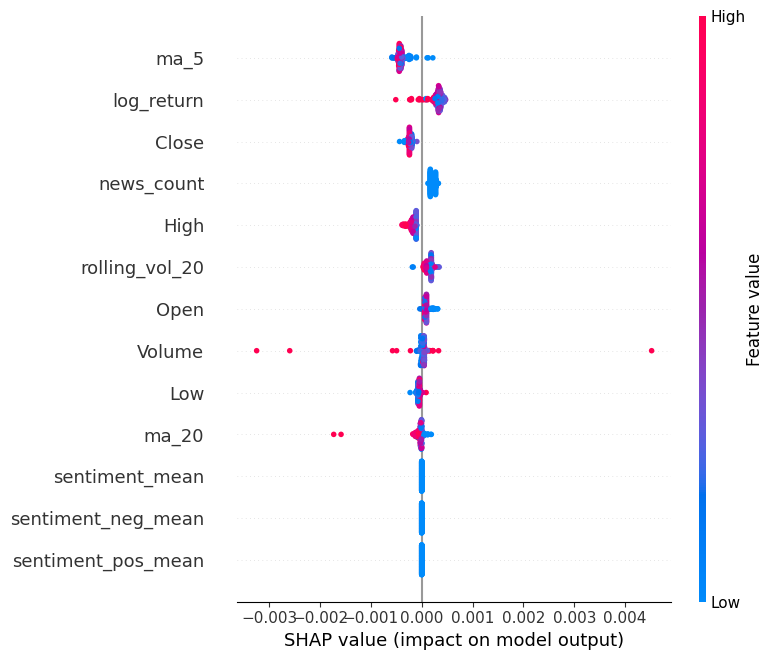

In [6]:
shap.summary_plot(shap_values, X_val_sample, feature_names=feature_cols)


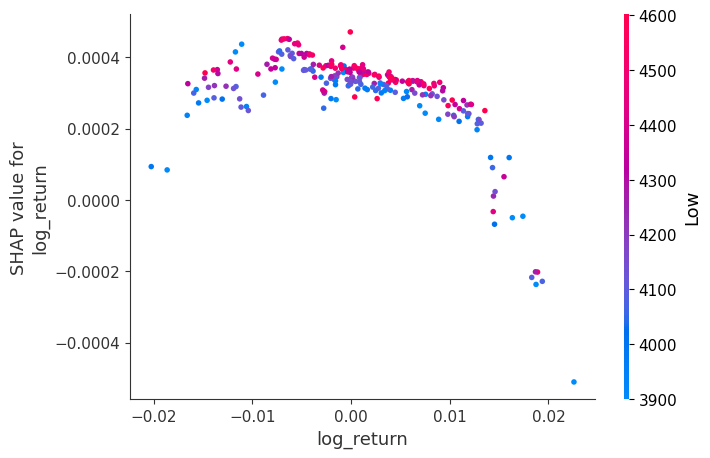

In [7]:
shap.dependence_plot(
    "log_return",
    shap_values,
    X_val_sample,
    feature_names=feature_cols,
)


In [8]:
import numpy as np

output_dir = Path("../02_Data/Processed")
output_dir.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    output_dir / "rf_shap_val_sample.npz",
    X_val_sample=X_val_sample,
    shap_values=shap_values,
    feature_names=np.array(feature_cols),
)


In [9]:
import numpy as np
import pandas as pd

# shap_values shape: (num_samples, num_features) for regression
abs_mean_importance = np.mean(np.abs(shap_values), axis=0)

df_global_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "mean_abs_shap": abs_mean_importance,
    }
).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

df_global_importance.head(20)


,feature,mean_abs_shap
0,ma_5,0.000406
1,log_return,0.000321
2,Close,0.000231
3,news_count,0.000213
4,High,0.000168
5,rolling_vol_20,0.000149
6,Open,0.000095
7,Volume,0.000086
8,Low,0.000059
9,ma_20,0.000053


In [10]:
from pathlib import Path

results_dir = Path("../05_Results")
results_dir.mkdir(parents=True, exist_ok=True)

global_importance_path = results_dir / "rf_shap_global_importance.csv"
df_global_importance.to_csv(global_importance_path, index=False)
global_importance_path


WindowsPath('../05_Results/rf_shap_global_importance.csv')

In [11]:
# Pick a single validation example to explain
idx = 0  # you can change this later or choose based on date

x_single = X_val[idx : idx + 1]  # shape (1, num_features)
y_true_single = y_val[idx]
y_pred_single = rf.predict(x_single)[0]
date_single = df_val.iloc[idx]["Date"]

print("Date:", date_single)
print("True next return:", y_true_single)
print("Predicted next return:", y_pred_single)


Date: 2023-01-03 00:00:00
True next return: 0.0075106945621389
Predicted next return: 0.0009789766259888039


In [12]:
shap_single = explainer.shap_values(x_single)  # shape (1, num_features)
shap_single = shap_single[0]

df_local = pd.DataFrame(
    {
        "feature": feature_cols,
        "value": x_single[0],
        "shap_value": shap_single,
    }
).sort_values("shap_value", ascending=False).reset_index(drop=True)

df_local.head(15)


,feature,value,shap_value
0,log_return,-4.008572e-03,0.000367
1,news_count,0.000000e+00,0.000286
2,Open,3.853290e+03,0.000231
3,ma_5,3.825078e+03,0.000218
4,ma_20,3.891793e+03,0.000063
5,rolling_vol_20,1.155886e-02,0.000030
6,Volume,3.959140e+09,0.000023
7,sentiment_pos_mean,0.000000e+00,0.000000
8,sentiment_mean,0.000000e+00,0.000000
9,sentiment_neg_mean,0.000000e+00,0.000000


In [13]:
local_path = results_dir / "rf_shap_example_local_explanation.csv"
df_local.to_csv(local_path, index=False)
local_path


WindowsPath('../05_Results/rf_shap_example_local_explanation.csv')

In [14]:
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_single,
    x_single,
    feature_names=feature_cols,
)


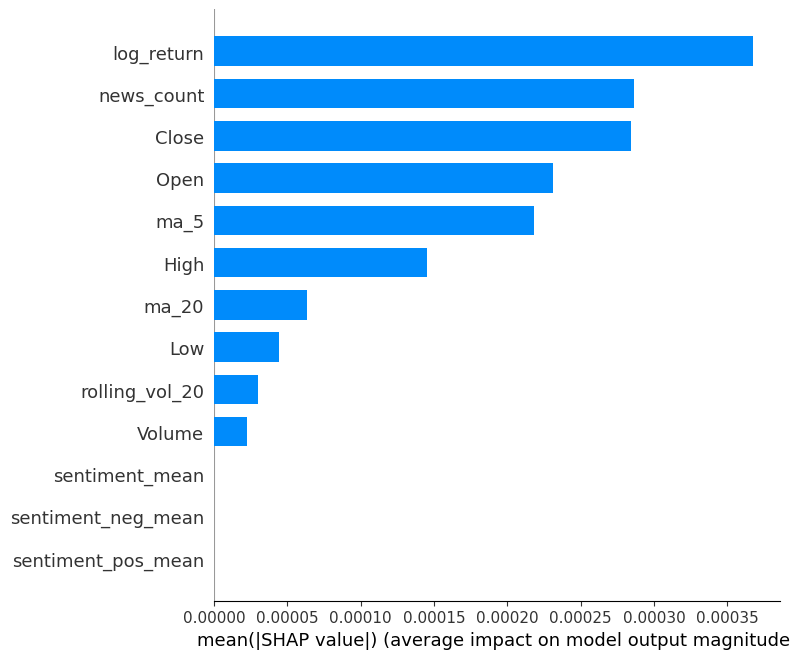

In [15]:
shap.summary_plot(
    shap_single.reshape(1, -1),
    x_single,
    feature_names=feature_cols,
    plot_type="bar",
)
